In [1]:
import cenpy
import contextily as ctx 
import segregation
%matplotlib inline
import matplotlib as mpl

In [2]:
import xyzservices.providers as xyz
import matplotlib.pyplot as plt #to make sure there are no errors when plotting a graph
from contextily import add_basemap
import folium 

In [3]:
import geopandas as gpd 
from census import Census 
from us import states
from shapely.geometry import Polygon

In [4]:
import pandas as pd

**Census Api**

In [5]:
acs=cenpy.products.ACS(year="latest")  # type: ignore
acs.filter_tables('RACE', by='description')


description  \
table_name                                                      
B02001                                                   RACE   
B02008      WHITE ALONE OR IN COMBINATION WITH ONE OR MORE...   
B02009      BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...   
B02010      AMERICAN INDIAN AND ALASKA NATIVE ALONE OR IN ...   
B02011      ASIAN ALONE OR IN COMBINATION WITH ONE OR MORE...   
B02012      NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALO...   
B02013      SOME OTHER RACE ALONE OR IN COMBINATION WITH O...   
B03002                      HISPANIC OR LATINO ORIGIN BY RACE   
B25006                                    RACE OF HOUSEHOLDER   
B98013      TOTAL POPULATION COVERAGE RATE BY WEIGHTING RA...   
B99021                                     ALLOCATION OF RACE   
C02003                                          DETAILED RACE   

                                                      columns  
table_name                                                     
B02001      [B02001_001E, B02001_002E, B02001_003E, B02001...  
B02008                                          [B02008_001E]  
B02009                                          [B02009_001E]  
B02010                                          [B02010_001E]  
B02011                                          [B02011_001E]  
B02012                                          [B02012_001E]  
B02013                                          [B02013_001E]  
B03002      [B03002_001E, B03002_002E, B03002_003E, B03002...  
B25006      [B25006_001E, B25006_002E, B25006_003E, B25006...  
B98013      [B98013_001E, B98013_002E, B98013_003E, B98013...  
B99021                [B99021_001E, B99021_002E, B99021_003E]  
C02003      [C02003_001E, C02003_002E, C02003_003E, C02003...

In [6]:
c = Census('f5e7cf46eaa83ae8323e6051f74d9ab363d0b957')

In [7]:
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
bxr_race = c.acs5.state_county_tract(fields = ('NAME', 'B02001_003E','B02001_001E' ),
                                      state_fips = states.TX.fips, 
                                      county_fips = "029",
                                      tract = "*",
                                      year = 2019)

In [39]:
bxr_df = pd.DataFrame(bxr_race)

In [40]:
print(bxr_df.head(2))
print('Shape: ', bxr_df.shape)

                                     NAME  B02001_003E  B02001_001E state  \
0  Census Tract 1109, Bexar County, Texas         46.0       1669.0    48   
1  Census Tract 1110, Bexar County, Texas        171.0       2948.0    48   

  county   tract  
0    029  110900  
1    029  111000  
Shape:  (366, 6)


access shapefile of bexar county

In [24]:
bxr_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_48_tract.zip")

print(bxr_census_tract)

     STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0         48      439  121609  48439121609  1216.09  Census Tract 1216.09   
1         48      187  210708  48187210708  2107.08  Census Tract 2107.08   
2         48      201  550301  48201550301  5503.01  Census Tract 5503.01   
3         48      201  550302  48201550302  5503.02  Census Tract 5503.02   
4         48      157  675800  48157675800     6758     Census Tract 6758   
...      ...      ...     ...          ...      ...                   ...   
5260      48      167  720501  48167720501  7205.01  Census Tract 7205.01   
5261      48      167  721202  48167721202  7212.02  Census Tract 7212.02   
5262      48      167  722002  48167722002  7220.02  Census Tract 7220.02   
5263      48      167  720301  48167720301  7203.01  Census Tract 7203.01   
5264      48      167  720503  48167720503  7205.03  Census Tract 7205.03   

      MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0   

In [38]:
print(bxr_census_tract.head(2))

print('Shape: ', bxr_census_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(bxr_census_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      48      439  121609  48439121609  1216.09  Census Tract 1216.09  G5020   
1      48      187  210708  48187210708  2107.08  Census Tract 2107.08  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  4036421  2474977  +32.6893777  -097.2140987   
1        S  2625635        0  +29.5747421  -098.2516707   

                                            geometry  
0  POLYGON ((-97.23369 32.67175, -97.23366 32.671...  
1  POLYGON ((-98.26254 29.57872, -98.26236 29.578...  
Shape:  (5265, 13)

The shapefile projection is: epsg:4269


<AxesSubplot:>

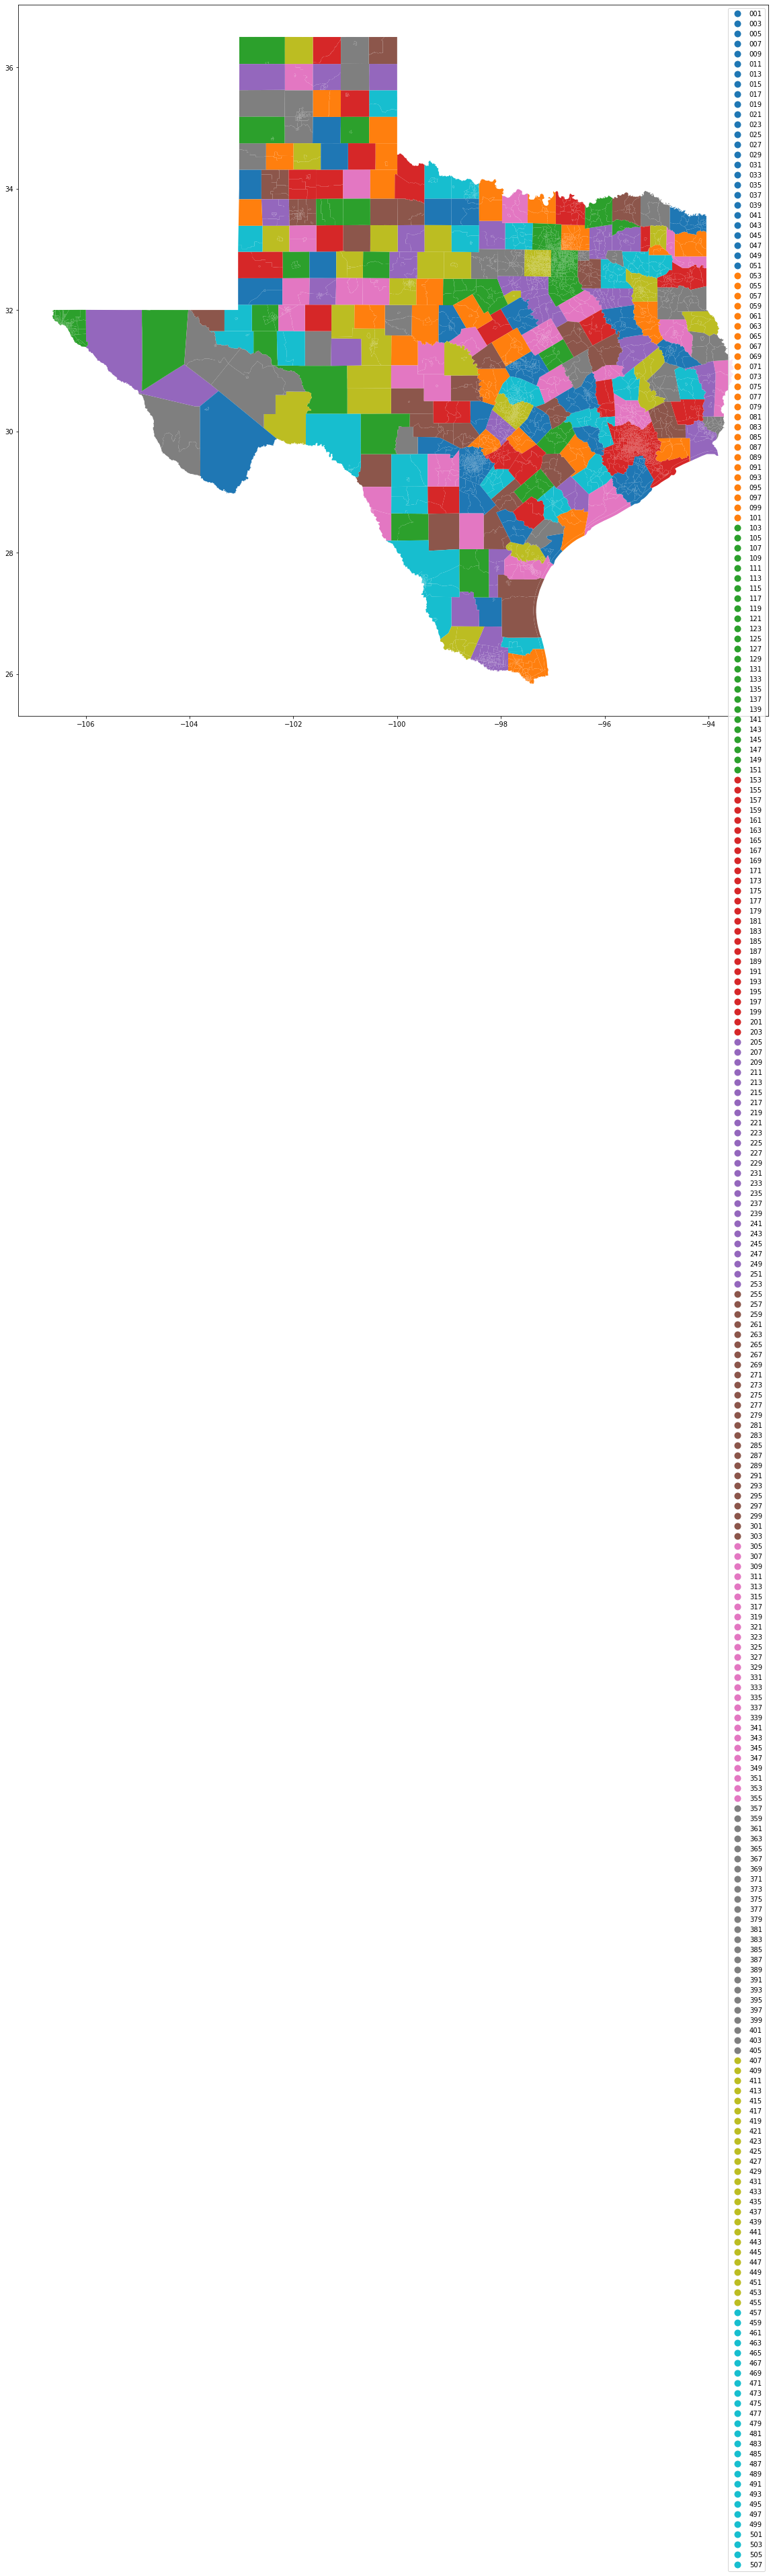

In [29]:
bxr_census_tract.plot('COUNTYFP', legend=True, figsize=(20,20))

performing dataframe operations

In [41]:
# Combine state, county, and tract columns together to create a new string and assign to new column
bxr_df["GEOID"] = bxr_df["state"] + bxr_df["county"] + bxr_df["tract"]

In [42]:
bxr_df.head(2)

NAME  B02001_003E  B02001_001E state  \
0  Census Tract 1109, Bexar County, Texas         46.0       1669.0    48   
1  Census Tract 1110, Bexar County, Texas        171.0       2948.0    48   

  county   tract        GEOID  
0    029  110900  48029110900  
1    029  111000  48029111000

In [43]:
# Remove columns
bxr_df = bxr_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
bxr_df.head(2)

NAME  B02001_003E  B02001_001E  \
0  Census Tract 1109, Bexar County, Texas         46.0       1669.0   
1  Census Tract 1110, Bexar County, Texas        171.0       2948.0   

         GEOID  
0  48029110900  
1  48029111000

In [44]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(bxr_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(bxr_census_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
B02001_003E    float64
B02001_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [45]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
bxr_merge = bxr_census_tract.merge(bxr_df, on = "GEOID")

# Show result
print(bxr_merge.head(2))
print('Shape: ', bxr_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      48      029  121000  48029121000   1210  Census Tract 1210  G5020   
1      48      029  161400  48029161400   1614  Census Tract 1614  G5020   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S   6640253   33515  +29.5322204  -098.4454653   
1        S  11020658       0  +29.3866196  -098.6178562   

                                            geometry  \
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...   
1  POLYGON ((-98.64202 29.39557, -98.64202 29.395...   

                                   NAME_y  B02001_003E  B02001_001E  
0  Census Tract 1210, Bexar County, Texas        363.0       7798.0  
1  Census Tract 1614, Bexar County, Texas       1344.0       6490.0  
Shape:  (366, 16)


In [46]:
# Create new dataframe from select columns
bxr_population_tract = bxr_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "B02001_003E", "B02001_001E"]]

# Show dataframe
print(bxr_population_tract.head(2))
print('Shape: ', bxr_population_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      48      029  121000  48029121000   
1      48      029  161400  48029161400   

                                            geometry  B02001_003E  B02001_001E  
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...        363.0       7798.0  
1  POLYGON ((-98.64202 29.39557, -98.64202 29.395...       1344.0       6490.0  
Shape:  (366, 7)


In [51]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
bxr_population_county = bxr_population_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(bxr_population_county.head(2))
print('Shape: ', bxr_population_county.shape)

                                                   geometry  B02001_003E  \
COUNTYFP                                                                   
029       POLYGON ((-98.32720 29.20987, -98.32724 29.209...     149706.0   

          B02001_001E  
COUNTYFP               
029         1952843.0  
Shape:  (1, 3)


In [61]:
# Get poverty rate and store values in new column
bxr_population_county["Population_Rate"] = (bxr_population_county["B02001_003E"] + bxr_population_county["B02001_001E"])/ bxr_population_county["B02001_001E"] * 100


# Show dataframe
bxr_population_county.head(2)  

geometry  B02001_003E  \
COUNTYFP                                                                   
029       POLYGON ((-98.32720 29.20987, -98.32724 29.209...     149706.0   

          B02001_001E  Population_Rate  
COUNTYFP                                
029         1952843.0       107.666054

Text(0.5, 1.0, 'Population Rates (%) in Bexar County')

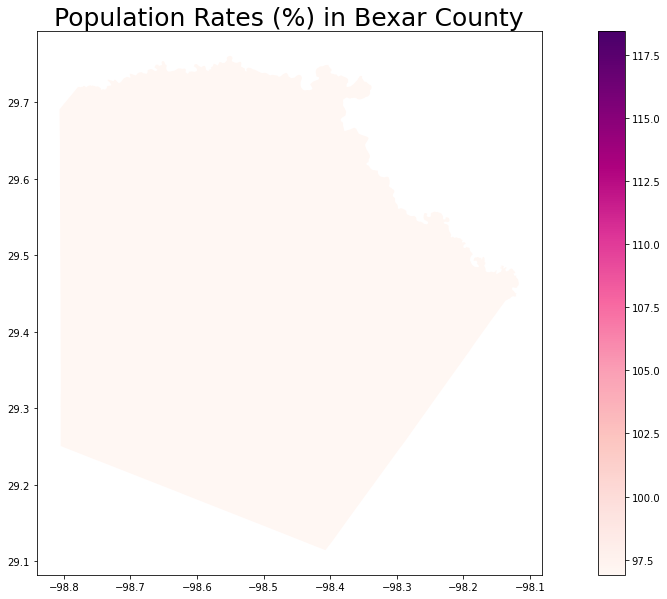

In [62]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
bxr_population_county.plot(column = "Population_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Population Rates (%) in Bexar County', fontdict = {'fontsize': '25', 'fontweight' : '3'})

**Bexar County RACE Population (percentage)**

In [ ]:
race = ['B02001_001E', #RACE all
                'B02001_003E' #BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...	
                ]
race

In [ ]:
bx_race_black = acs.from_county('Bexar County, TX', variables=race)
bx_race_black

In [ ]:
bx_race_black_basemap, bx_race_black_extent = ctx.bounds2img(*bx_race_black.total_bounds, zoom=10,   
                                            source=ctx.providers.OpenStreetMap.Mapnik )

In [ ]:
f,ax = plt.subplots(1,1, figsize=(20,16))

plt.rcParams['legend.title_fontsize'] = 'medium'

plt.rcParams['font.size'] = 16

plt.rcParams['font.weight'] = 600

ax.imshow(bx_race_black_basemap, extent=bx_race_black_extent, interpolation='sinc')
bx_race_black['pct_black'] = bx_race_black.eval('B02001_003E / B02001_001E')*100  # type: ignore

bx_race_black.plot('pct_black', edgecolor='white',linewidth=.2, cmap='CMRmap_r', ax = ax,  # type: ignore
                    alpha=.7, legend=True,
                    legend_kwds={ 'label': "Percentage of Black/African American residences living in Bexar County",'orientation': "horizontal", 'pad':.01})  # type: ignore

plt.title(
    "\nBexar County\n Black and African American Population (percentage)\n",
    fontsize=20,
    loc='center',
    fontweight='bold',
    #style='italic',
    family='monospace')

plt.style.use('dark_background')

ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)